# SatCen Change Detection visualization via Research Object

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

This notebook produces a Change Detection analysis using the VRE processing service and publishes the results as a Research Object available on the SatCen VRE.

## <a name="workflow">Workflow

#### Import the Python packages

In [1]:
import requests
import zipfile
import gdal
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os

#### Access the Research Object

In [2]:
ro_url = 'http://sandbox.rohub.org/rodl/ROs/cde-481/'   

In [3]:
headers = { 'Accept': 'application/zip' } 

In [4]:
r = requests.get(ro_url)

In [5]:
r = requests.get(ro_url, headers=headers)

#### Read and plot the change detection image

In [6]:
ro_archive = 'ro.zip'



In [7]:
open(ro_archive, 'wb').write(r.content)

In [8]:
zip=zipfile.ZipFile(ro_archive)

for index, elem in enumerate(zip.namelist()):
    print '%s - %s' % (index, elem)

0 - .ro/evo_info.ttl
1 - .ro/manifest.rdf
2 - change_detection.tif
3 - 6f5d73e8-18ca-4aff-b26d-5821e5a417b2.rdf
4 - title.rdf
5 - 57a0424f-5a89-4121-8f7f-3bb810e7ed00.ttl


In [9]:
change_detection = str(zip.namelist()[2])

In [10]:
gdal.FileFromMemBuffer('/vsimem/change_detection', zip.read(change_detection))

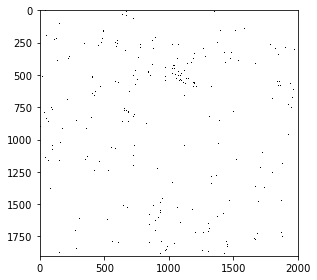

In [11]:
ds = gdal.Open('/vsimem/change_detection')

band = ds.GetRasterBand(1)
imgplot = plt.imshow (band.ReadAsArray().astype(numpy.float), cmap=plt.cm.binary, vmin=0, vmax = 1)

    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

#### Inspect the Research Object metadata

In [12]:
zip=zipfile.ZipFile(ro_archive)
f=zip.open(str(zip.namelist()[1]))
contents=f.read()
f.close()

In [13]:
import lxml.etree as etree

root = etree.fromstring(contents)

In [14]:
resources = []

for index, elem in enumerate(root.xpath('/a:RDF/a:Description', 
                          namespaces={'a':'http://www.w3.org/1999/02/22-rdf-syntax-ns#'})):

    if 'https://catalog.terradue.com/' in elem.attrib['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about']:
        resources.append(elem.attrib['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'])

What are the catalog resources?

In [15]:
resources

['https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18',
 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D']

Inspect the metadata and stage-in the Sentinel-1 product

In [16]:
import cioppy
ciop = cioppy.Cioppy()

In [22]:
metadata = ciop.search(end_point=resources[0], 
                       model='EOP', 
                       params=dict([('do','terradue')]), 
                       output_fields='enclosure,identifier,startdate,enddate,published,updated,related,productType,parentIdentifier,orbitNumber,orbitDirection,track,frame,swathIdentifier,platform,operationalMode,polarisationChannels,wrsLongitudeGrid,processingLevel,wkt') 
                                               

In [23]:
metadata[0]['orbitNumber']


'20628'

In [24]:
metadata[0]['enclosure']

'https://store.terradue.com/download/sentinel1/files/v1/S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18'

In [20]:
local_path = ciop.copy(metadata[0]['enclosure'],extract=False,target='./')

In [21]:
os.remove(local_path) 